# Sports Political Donations: Exploratory Data Analysis, Inference, & Prediction
## By: Anna Wallin

## Introduction:
I am using data based on political donations by different sports owners from different leagues. Sports teams owners are rich and therefore powerful individuals, and the way that they donate can have influences/provide insights about the politics of the area. My data set is a CSV file with the owner, team, league, recipient, amount, election year, & party. 

## Motivations/Overview of this Project:

I am interested in not only the political skew of the different sports teams leagues (see sections 1 & 2), but also seeing if geography and/or voting habits in geographical areas indicate how the sports team owner in that area will donate (see section 3).

In [644]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Part 1: EDA 

In [645]:
donations = pd.read_csv("sports-political-donations.csv")
donations.head()

,Owner,Team,League,Recipient,Amount,Election Year,Party
0,Adam Silver,Commissioner,NBA,WRIGHT 2016,"$4,000",2016,Democrat
1,Adam Silver,Commissioner,NBA,BIDEN FOR PRESIDENT,"$2,800",2020,Democrat
2,Adam Silver,Commissioner,NBA,CORY 2020,"$2,700",2020,Democrat
3,Adam Silver,Commissioner,NBA,Kamala Harris for the People,"$2,700",2020,Democrat
4,Adam Silver,Commissioner,NBA,Win The Era PAC,"$2,700",2020,Democrat


In [646]:
donations.shape

(2798, 7)

### 1a. Data Cleaning

I noticed as I was doing data that some of the leagues were not grouping up correctly, likely due to formatting errors. I researched how I can best clean the data to get rid of random blank spaces and incorrect formatting.

In [647]:
for column in donations.select_dtypes(include=['object']).columns:
    donations[column] = donations[column].apply(lambda x: re.sub(r'\s+', ' ', str(x)).strip().upper())

As shown below, some of the owners own multiple teams across different leagues, so I first need to make sure there is only one value in each column to follow one of the principles of tidy data.

In [648]:
donations["Team"].loc[640]

'PHILADELPHIA 76ERS, NEW JERSEY DEVILS'

I adjusted the data by splitting across the comma and then exploding the data, adding a new row with that data in it.

In [649]:
donations['League'] = donations['League'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
donations['Team'] = donations['Team'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

donations = donations.explode(['League', 'Team'])

I need to clean out the dollar signs so that doesn't affect the data. 

In [650]:
donations['Amount'] = donations['Amount'].replace('[$,]', '', regex=True).astype(float)

I want to get rid of the N/A & Indepdent because neither tell me about the party breakdown of the donations if no party is assigned.

In [651]:
donations = donations[~donations['Party'].isin(['NAN'])]
donations = donations[~donations['Party'].isin(['INDEPENDENT'])]
donations.head()

,Owner,Team,League,Recipient,Amount,Election Year,Party
0,ADAM SILVER,COMMISSIONER,NBA,WRIGHT 2016,4000.0,2016,DEMOCRAT
1,ADAM SILVER,COMMISSIONER,NBA,BIDEN FOR PRESIDENT,2800.0,2020,DEMOCRAT
2,ADAM SILVER,COMMISSIONER,NBA,CORY 2020,2700.0,2020,DEMOCRAT
3,ADAM SILVER,COMMISSIONER,NBA,KAMALA HARRIS FOR THE PEOPLE,2700.0,2020,DEMOCRAT
4,ADAM SILVER,COMMISSIONER,NBA,WIN THE ERA PAC,2700.0,2020,DEMOCRAT


I notice a small issue within my project data: the Bipartisan, but mostly leanings. I decided to just categorize them as what they are "mostly" marked as. 

In [652]:
donations['Party'] = donations['Party'].replace('BIPARTISAN, BUT MOSTLY DEMOCRATIC', 'DEMOCRAT')
donations['Party'] = donations['Party'].replace('BIPARTISAN, BUT MOSTLY REPUBLICAN', 'REPUBLICAN')

### 1b: Exploratory Data Analysis

To get oriented with the data, I chose to see how the donations have varied over the year for the differing political parties. Interestingly enough, donations have decreased since 2016 for all of the parties. It also becomes clear that the data is highly skewed toward Republican focused donations.

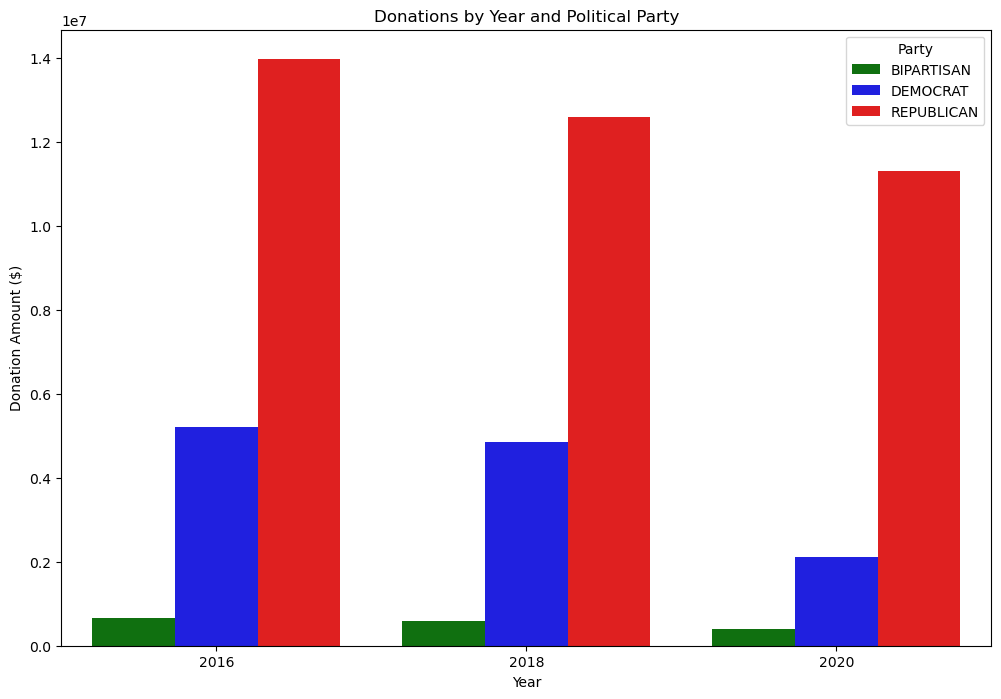

In [653]:
donations_by_party = donations.groupby(['Election Year', 'Party'])['Amount'].sum().reset_index()
# Plotting
plt.figure(figsize=(12,8))
sns.barplot(data=donations_by_party, x='Election Year', y='Amount', hue = 'Party', palette=['green', 'blue', 'red'])
plt.title('Donations by Year and Political Party')
plt.ylabel('Donation Amount ($)')
plt.xlabel('Year')
plt.show()

I want to see how much each league has donated total and create a graph of that.

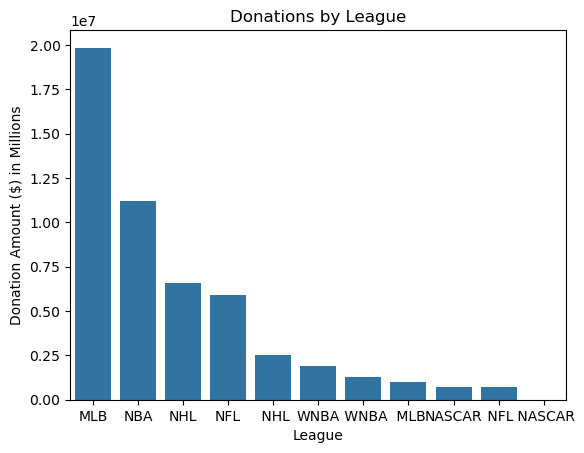

In [654]:
total_donations_per_league = donations.groupby('League')['Amount'].sum().reset_index()
total_donations_per_league = total_donations_per_league.sort_values(ascending = False, by = ['Amount'])
sns.barplot(data=total_donations_per_league, x='League', y='Amount')
plt.title('Donations by League')
plt.ylabel('Donation Amount ($) in Millions')
plt.xlabel('League')
plt.show()

I know that the WNBA is the only women's sports teams in this list, so I would like to see if the political donations of those in charge of women's sports at all differ from men's donations.

In [655]:
WNBA_filtered = donations[donations["League"] == "WNBA"]
womens_donations = WNBA_filtered.groupby('Party')['Amount'].sum().reset_index().sort_values(ascending = False, by = ["Amount"])
total_donations = womens_donations['Amount'].sum()
womens_donations['Proportion'] = womens_donations['Amount'] / total_donations
womens_donations

,Party,Amount,Proportion
2,REPUBLICAN,1055552.0,0.560289
1,DEMOCRAT,824640.0,0.437720
0,BIPARTISAN,3750.0,0.001991


In [656]:
men_filtered = donations[~donations['League'].isin(['WNBA'])]
men_donations = men_filtered.groupby('Party')['Amount'].sum().reset_index().sort_values(ascending = False, by = ["Amount"])
total_donations = men_donations['Amount'].sum()
men_donations['Proportion'] = men_donations['Amount'] / total_donations
men_donations

,Party,Amount,Proportion
2,REPUBLICAN,36785057.0,0.739392
1,DEMOCRAT,11345420.0,0.228047
0,BIPARTISAN,1619949.0,0.032562


Visualizing them next to each other:

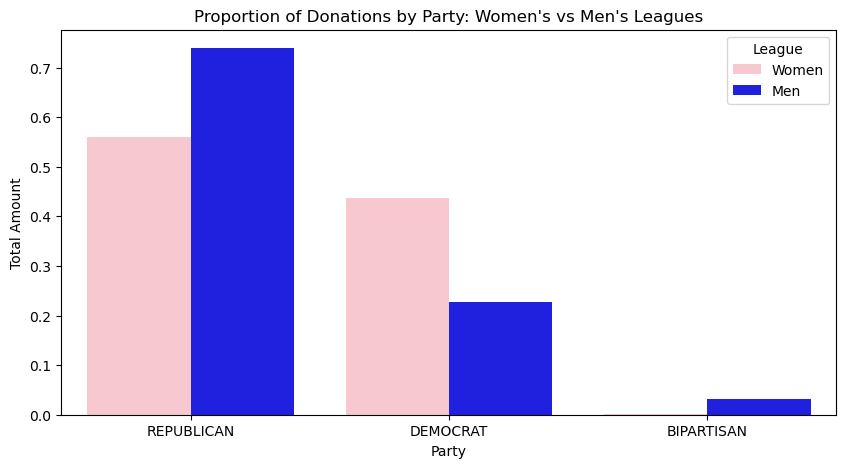

In [657]:
womens_donations['League'] = 'Women'
men_donations['League'] = 'Men'

combined_donations = pd.concat([womens_donations, men_donations])

# Grouped barplot
plt.figure(figsize = (10,5))
sns.barplot(x='Party', y='Proportion', hue='League', data=combined_donations, palette=['pink', 'blue'])

# Titles and labels
plt.title("Proportion of Donations by Party: Women's vs Men's Leagues")
plt.xlabel("Party")
plt.ylabel("Total Amount")
plt.legend(title='League')

# Display the plot
plt.show()

I want to geographically group the teams and see what part of the country they are from and the political party donation patterns from those areas. I am setting up the stage for my prediction so I can compare the data to how people in those areas tend to vote.

First I read in the file:

In [658]:
cities = pd.read_csv("uscities.csv")
cities.head(5)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18908608,11080.3,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,11922389,3184.7,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8497759,4614.5,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6080145,4758.9,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Houston,Houston,TX,Texas,48201,Harris,29.7860,-95.3885,5970127,1384.0,shape,False,True,America/Chicago,1,77069 77068 77061 77060 77063 77062 77065 7706...,1840020925


I don't need all of the info so I filter for what could be helpful. I also need to make the data set all uppercase to match my donations data set.

In [659]:
cities = cities[["city", "state_name", "lat", "lng"]]
cities = cities.apply(lambda col: col.str.upper() if col.dtype == 'object' else col)
cities

,city,state_name,lat,lng
0,NEW YORK,NEW YORK,40.6943,-73.9249
1,LOS ANGELES,CALIFORNIA,34.1141,-118.4068
2,CHICAGO,ILLINOIS,41.8375,-87.6866
3,MIAMI,FLORIDA,25.7840,-80.2101
4,HOUSTON,TEXAS,29.7860,-95.3885
...,...,...,...,...
31115,KOHATK,ARIZONA,32.5781,-112.0032
31116,IRONVILLE,PENNSYLVANIA,40.6586,-78.2155
31117,NEWKIRK,NEW MEXICO,35.0635,-104.2715
31118,FALCON VILLAGE,TEXAS,26.5652,-99.1341


Since some of the sports teams only have state names and not city names, I need to find the average latitude and longitude of the states, which I can do by grouping the state names and making a new data set with those values.

In [660]:
state = cities.groupby('state_name', as_index=False).agg({
    'lat': 'mean',
    'lng': 'mean'
})
state.head()

,state_name,lat,lng
0,ALABAMA,32.943928,-86.745325
1,ALASKA,61.421072,-149.984001
2,ARIZONA,33.892452,-111.588676
3,ARKANSAS,35.079339,-92.386757
4,CALIFORNIA,36.926551,-120.175087


Because I want to check to see if any of my data from the donations Teams are either a state or a city, I create a list that I can check:

In [661]:
state_city_names = pd.concat([cities['state_name'], cities['city']]).str.upper().unique()
state_city_names 

array(['NEW YORK', 'CALIFORNIA', 'ILLINOIS', ..., 'MOUNT WILSON',
       'KOHATK', 'FALCON VILLAGE'], dtype=object)

In [662]:
location = donations.copy()

location = location[["Team", "Amount", "Party"]]

# New column with the matched locations
location['matched_location'] = location['Team'].apply(
    lambda name: ','.join([word for word in name.split() if word in state_city_names])
)

# Filter to keep only rows where there was a match
location = location[location['matched_location'] != '']

In [663]:
location["Team"].unique()

array(['ARIZONA COYOTES', 'TENNESSEE TITANS', 'RICHARD PETTY MOTORSPORTS',
       'LOS ANGELES ANGELS OF ANAHEIM', 'ATLANTA FALCONS',
       'PITTSBURGH STEELERS', 'DALLAS WINGS', 'VEGAS GOLDEN KNIGHTS',
       'PITTSBURGH PIRATES', 'TEXAS RANGERS', 'MIAMI MARLINS',
       'TAMPA BAY BUCCANEERS', 'SAN FRANCISCO GIANTS', 'COLORADO ROCKIES',
       'BOSTON BRUINS', 'DETROIT TIGERS', ' DETROIT RED WINGS',
       'NEW YORK JETS', 'KANSAS CITY CHIEFS', 'OKLAHOMA CITY THUNDER',
       'MINNESOTA WILD', 'HOUSTON TEXANS', 'ORLANDO MAGIC',
       'CLEVELAND CAVALIERS', 'WASHINGTON FOOTBALL TEAM',
       'PHILADELPHIA FLYERS', 'CAROLINA PANTHERS', 'PHILADELPHIA 76ERS',
       ' NEW JERSEY DEVILS', 'SEATTLE KRAKEN', 'SEATTLE STORM',
       'SAN FRANCISCO 49ERS', 'DENVER NUGGETS', ' COLORADO AVALANCHE',
       'LOS ANGELES KINGS', 'NEW YORK METS', 'UTAH JAZZ',
       'NEW ORLEANS PELICANS', ' NEW ORLEANS SAINTS',
       'STEWART HAAS RACING', 'CHICAGO BEARS', 'MINNESOTA TIMBERWOLVES',
       ' MIN

Looking at the unique values an issue I see is that New York is both a city and a state, and same with Washington. I decided to drop New York and Washington from the states dataset bc the teams refer to the city. I also decided to drop Portland, Maine, from the cities because Portland is meant to refer to Oregon in this data set. Obviously this method isn't perfect, but it will get more accurate data. 

In [664]:
state = state[~state['state_name'].isin(['NEW YORK', 'WASHINGTON'])]
cities = cities[~((cities['city'] == 'PORTLAND') & (cities['state_name'] == 'MAINE'))]

Adding this long and lat to the new location dataset:

In [665]:
def get_lat_lng_for_team_from_cities(team_name, cities_df):
    for city in cities_df['city']:
        if city in team_name: 
            # Get the corresponding latitude and longitude from the cities DataFrame
            city_data = cities_df[cities_df['city'] == city].iloc[0]
            return city_data['lat'], city_data['lng']
    return None, None  # If no city match is found

def get_lat_lng_for_team_from_states(team_name, state_df):
    for state in state_df['state_name']:
        if state in team_name: 
            # Get the corresponding latitude and longitude from the states DataFrame
            state_data = state_df[state_df['state_name'] == state].iloc[0]
            return state_data['lat'], state_data['lng']
    return None, None  # If no state match is found

# First check for city matches, then check for state matches if no city match is found
def get_lat_lng_for_team(team_name, cities_df, state_df):
    lat, lng = get_lat_lng_for_team_from_cities(team_name, cities_df)
    if lat is None and lng is None:  # If no city match, check state
        lat, lng = get_lat_lng_for_team_from_states(team_name, state_df)
    return lat, lng

# Apply the function to get latitude and longitude for each team
location['latitude'], location['longitude'] = zip(*location['Team'].apply(lambda team: get_lat_lng_for_team(team, cities, state)))

Then, I group these by location and find which party is predominant for each specific place.

In [666]:
location_grouped = location.groupby(['latitude', 'longitude', 'Party']).size().reset_index(name='count')
location_predominant_party = location_grouped.loc[location_grouped.groupby(['latitude', 'longitude'])['count'].idxmax()]

location_predominant_party.head()

,latitude,longitude,Party,count
0,18.3643,-66.5611,BIPARTISAN,3
2,18.4054,-65.9792,REPUBLICAN,37
5,25.7840,-80.2101,REPUBLICAN,152
6,27.4830,-81.9097,DEMOCRAT,3
9,27.9945,-82.4447,REPUBLICAN,19


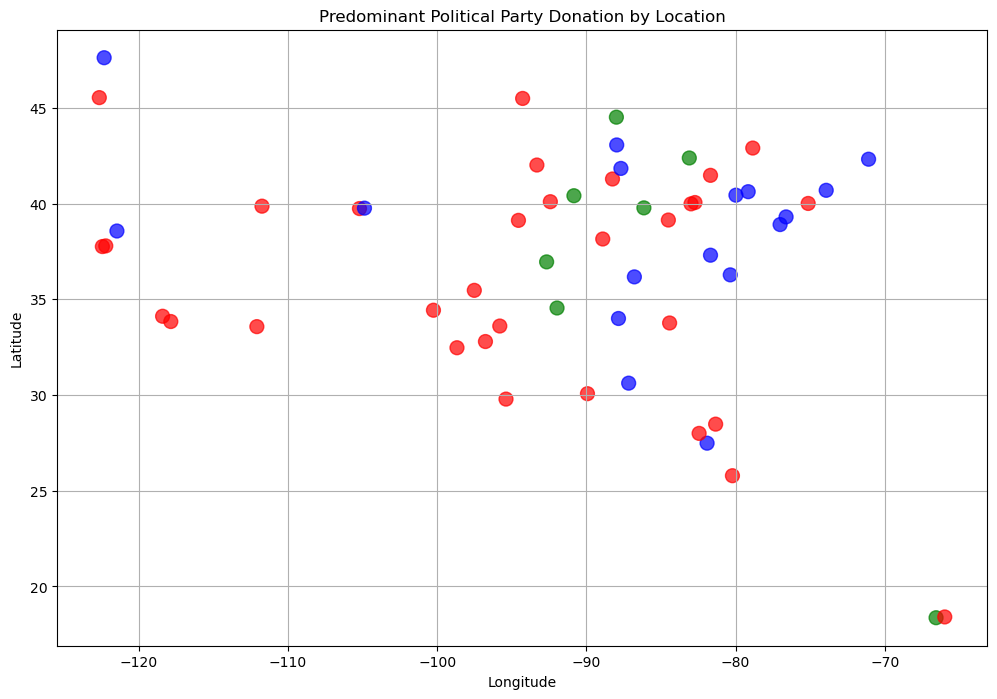

In [667]:
party_colors = {
    "DEMOCRAT": 'blue',
    "BIPARTISAN": 'green',
    "REPUBLICAN": 'red'
}

# Map the party to its corresponding color
location_predominant_party['color'] = location_predominant_party['Party'].map(party_colors)

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    location_predominant_party['longitude'],
    location_predominant_party['latitude'],
    c=location_predominant_party['color'],
    alpha=0.7,
    s=100
)

# Customize the plot
plt.title('Predominant Political Party Donation by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

I want to look at who the highest donors are and how much they paid:

In [668]:
highest_donors = donations.groupby(["Owner", "Party", "League"])["Amount"].sum().reset_index().sort_values(ascending = False, by = ["Amount"])

In [669]:
highest_donors 

,Owner,Party,League,Amount
35,CHARLES JOHNSON,REPUBLICAN,MLB,11030500.0
49,DAN DEVOS,REPUBLICAN,NBA,2310400.0
228,PETER ANGELOS,DEMOCRAT,MLB,2082772.0
235,PHILIP F. ANSCHUTZ,REPUBLICAN,NHL,1776700.0
193,LAURA RICKETTS,DEMOCRAT,MLB,1715424.0
...,...,...,...,...
316,WYC GROUSBECK,DEMOCRAT,NBA,500.0
102,HARVEY ALTER,DEMOCRAT,WNBA,500.0
69,DEAN A. SPANOS,DEMOCRAT,NFL,250.0
309,TROY STAFFORD,REPUBLICAN,NASCAR,250.0


I want to see how much each league donates per party & create a graph of that:

In [670]:
donations_by_league_party = donations.groupby(["League", "Party"])["Amount"].sum().reset_index().sort_values(ascending = False, by = ["Amount"])
donations_by_league_party.head()

,League,Party,Amount
15,MLB,REPUBLICAN,14653361.0
21,NBA,REPUBLICAN,8446100.0
27,NHL,REPUBLICAN,5143916.0
14,MLB,DEMOCRAT,4756629.0
24,NFL,REPUBLICAN,4633770.0


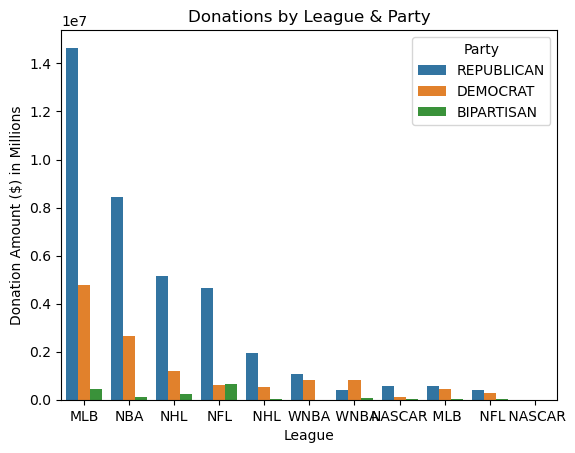

In [671]:
sns.barplot(data=donations_by_league_party, x='League', y='Amount', hue = 'Party')
plt.title('Donations by League & Party')
plt.ylabel('Donation Amount ($) in Millions')
plt.xlabel('League')
plt.show()

Now I look at those owners who donated to multiple political groups.

In [672]:
unique_donations = donations.groupby(["Owner", "Party"]).size().reset_index(name="Count")
multi_party_donors = (
    unique_donations.groupby("Owner")["Party"]
    .nunique()
    .reset_index()
    .rename(columns={"Party": "Multiple Parties"})
)
multi_party_donors = multi_party_donors[multi_party_donors["Multiple Parties"] > 1].sort_values(ascending = False, by = ["Multiple Parties"])

multi_party_donors.head()

,Owner,Multiple Parties
57,HERBERT SIMON,3
70,JERRY JONES,3
55,HENRY AND SUSAN SAMUELI,3
56,HERBERT FRITCH,3
108,MICKY ARISON,3


In [673]:
f"There are {len(multi_party_donors)} donors who donated across more than 1 party!"

'There are 87 donors who donated across more than 1 party!'

## PART 1 CONCLUSIONS:
After working with my data for a while, it is clear that there are far more Republican contributions, and that the MLB owners are some of the biggest contributors. Donations have also decreased since 2016 across the board. I notice that a lot of owners donate across multiple parties, which I found suprising. I was also suprised by my data when I grouped by latitude and longitude, because there was fewer conclusively republican data sets than I would have imagined. I also observed that the WNBA had a lot higher proportion of democratic donations than the male leagues, which was unsuprsing considering the political lean of women vs men in this country.

I am still curious to know if male owners contribute to one party more than female owners, and to go further with this idea of gender and politics. I also wonder if donation amount is correlated to the net worth of the owners. Overall, I am hoping to find some sort of answers in the later stages of my project to see if the the donations from these owners correspond with the political beliefs of regular people (whether that be due to geographical political leanings or political beliefs among certain fanbases).

## Part 2: Inference 

I already explored the idea of owners of female leagues vs male leagues, but I want to go further and create a hypothesis. As a reminder, here is the barchart I already created exploring this idea:

In [674]:
WNBA_filtered = donations[donations["League"] == "WNBA"]
womens_donations = WNBA_filtered.groupby('Party')['Amount'].sum().reset_index().sort_values(ascending = False, by = ["Amount"])
total_donations = womens_donations['Amount'].sum()
womens_donations['Proportion'] = womens_donations['Amount'] / total_donations
womens_donations

,Party,Amount,Proportion
2,REPUBLICAN,1055552.0,0.560289
1,DEMOCRAT,824640.0,0.437720
0,BIPARTISAN,3750.0,0.001991


In [675]:
men_filtered = donations[~donations['League'].isin(['WNBA'])]
men_donations = men_filtered.groupby('Party')['Amount'].sum().reset_index().sort_values(ascending = False, by = ["Amount"])
total_donations = men_donations['Amount'].sum()
men_donations['Proportion'] = men_donations['Amount'] / total_donations
men_donations

,Party,Amount,Proportion
2,REPUBLICAN,36785057.0,0.739392
1,DEMOCRAT,11345420.0,0.228047
0,BIPARTISAN,1619949.0,0.032562


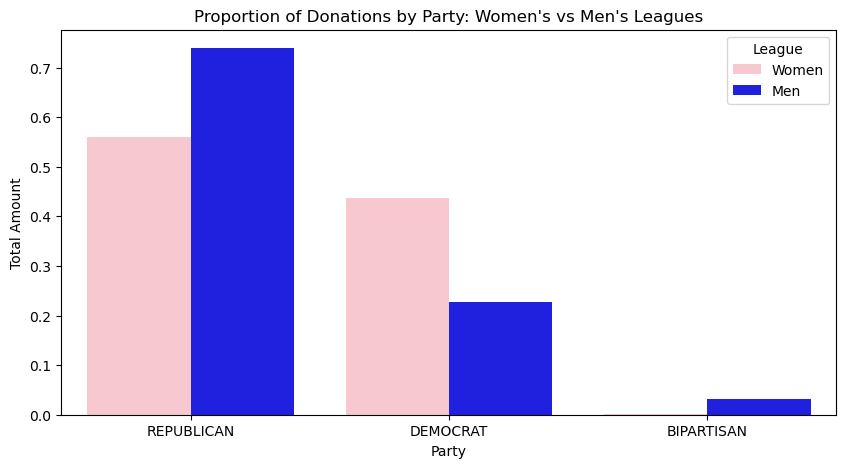

In [676]:
womens_donations['League'] = 'Women'
men_donations['League'] = 'Men'

combined_donations = pd.concat([womens_donations, men_donations])

# Grouped barplot
plt.figure(figsize = (10,5))
sns.barplot(x='Party', y='Proportion', hue='League', data=combined_donations, palette=['pink', 'blue'])

# Titles and labels
plt.title("Proportion of Donations by Party: Women's vs Men's Leagues")
plt.xlabel("Party")
plt.ylabel("Total Amount")
plt.legend(title='League')

# Display the plot
plt.show()

Now I want to be more specific and group by both league and party to establish the effect of a categorical predictor variable (league ownership) on the proportion of donations to Democratic causes. 

### Null Hypothesis: 
There is no difference in the likelihood of donating to Democratic causes between WNBA owners and the owners of other leagues.

### Alternative Hypothesis: 
WNBA owners are more likely to contribute to Democratic causes than owners of other leagues.

In [677]:
# Grouping by league and party
league_donations = donations.groupby(['League', 'Party'])['Amount'].sum().reset_index()

# Calculate proportions within each league
league_totals = league_donations.groupby('League')['Amount'].sum().reset_index()
league_donations = league_donations.merge(league_totals, on='League', suffixes=('', '_total'))
league_donations['Proportion'] = league_donations['Amount'] / league_donations['Amount_total']
league_donations.head()

,League,Party,Amount,Amount_total,Proportion
0,MLB,BIPARTISAN,25000.0,1018875.0,0.024537
1,MLB,DEMOCRAT,429975.0,1018875.0,0.422010
2,MLB,REPUBLICAN,563900.0,1018875.0,0.553454
3,NASCAR,REPUBLICAN,2700.0,2700.0,1.000000
4,NFL,BIPARTISAN,25000.0,702300.0,0.035597


#### Critical evaluation using bootstrapping:

I am going to bootstrap my donation data for the WNBA people donating to democratic causes vs the other leagues donating to democratic causes.

In [678]:
# Bootstrapping function for the proportions

def bootstrap_proportions(data, league, party, n_bootstraps=1000):
    proportions = []
    for i in range(n_bootstraps):
        sample = data.sample(frac=1, replace=True)
        league_data = sample[sample['League'] == league]
        party_data = league_data[league_data['Party'] == party]
        total_amount = league_data['Amount'].sum()
        party_amount = party_data['Amount'].sum()
        proportions.append(party_amount / total_amount)
    return proportions

In [679]:
# Bootstrapping for WNBA and other leagues democratic donations
wnba_proportions = bootstrap_proportions(donations, 'WNBA', 'DEMOCRAT')
nba_proportions = bootstrap_proportions(donations, 'NBA', 'DEMOCRAT')
mlb_proportions = bootstrap_proportions(donations, 'MLB', 'DEMOCRAT')
nascar_proportions = bootstrap_proportions(donations, 'NASCAR', 'DEMOCRAT')
nfl_proportions = bootstrap_proportions(donations, 'NFL', 'DEMOCRAT')
nhl_proportions = bootstrap_proportions(donations, 'NHL', 'DEMOCRAT')

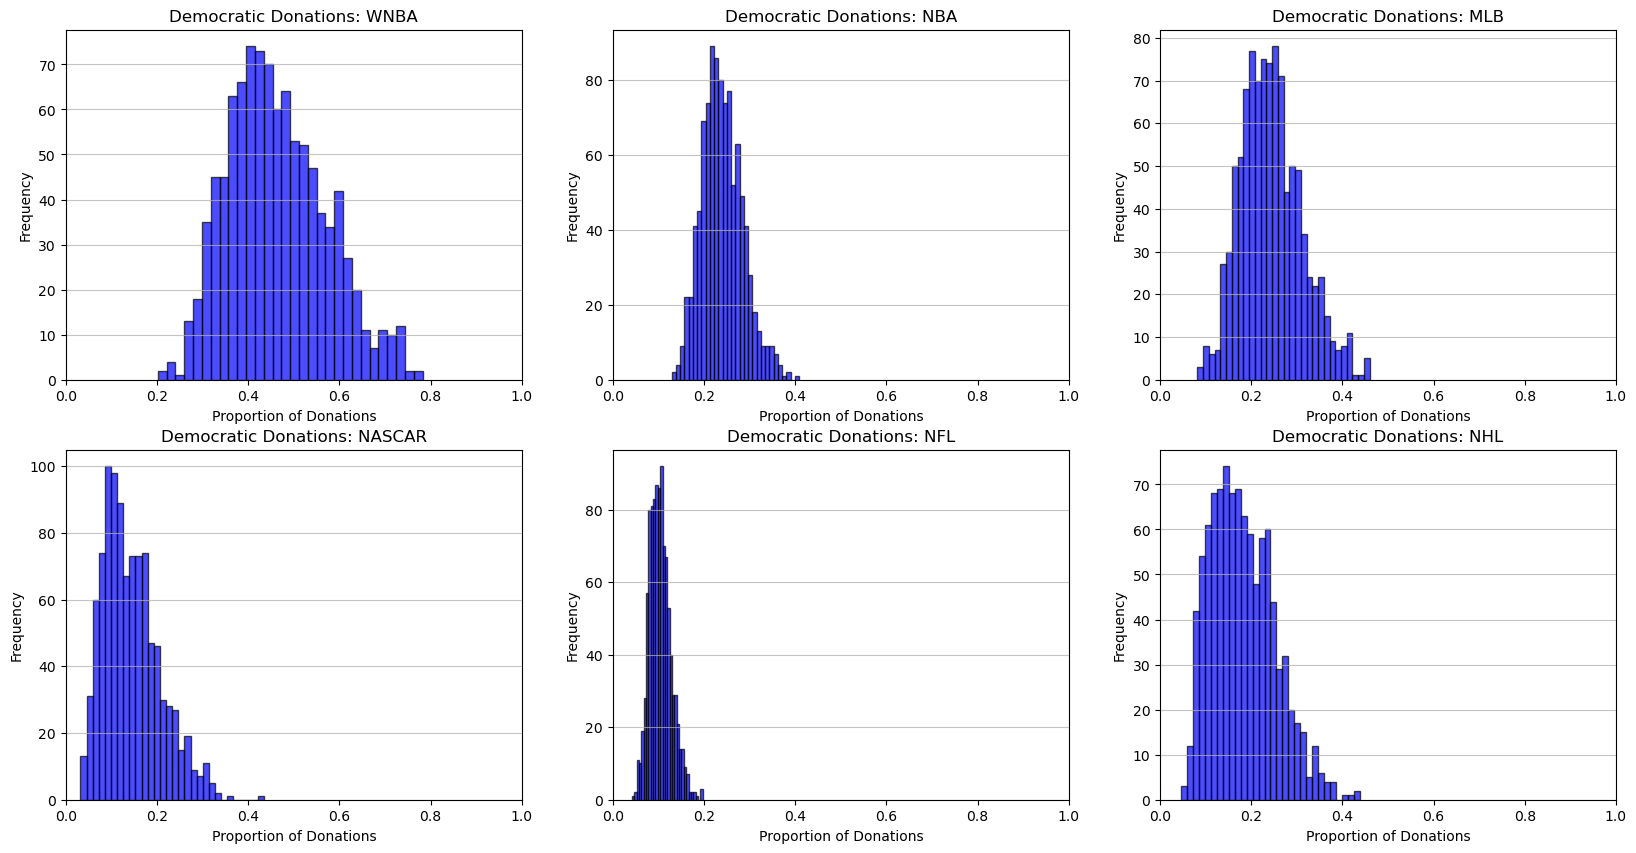

In [680]:
# Define the league names for labeling
leagues = ['WNBA', 'NBA', 'MLB', 'NASCAR', 'NFL', 'NHL']
proportions_list = [wnba_proportions, nba_proportions, mlb_proportions, 
                    nascar_proportions, nfl_proportions, nhl_proportions]

# Create histograms for each league
plt.figure(figsize=(20, 10))  

for i, proportions in enumerate(proportions_list):
    plt.subplot(2, 3, i + 1)  # Create a subplot for each league
    plt.hist(proportions, bins=30, alpha=0.7, color='blue', edgecolor = 'black')  # Create histogram
    plt.title(f'Democratic Donations: {leagues[i]}')  # Set the title for each subplot
    plt.xlabel('Proportion of Donations')  
    plt.ylabel('Frequency')  
    plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
    plt.grid(axis='y', alpha=0.75)  

plt.show()

#### Critical evaluation using confidence intervals:
I generated 95% confidence intervals to represent the range of true proportion of contributions to Democratic causes by the different league owners.

In [681]:
# List of leagues
leagues = ['WNBA', 'NBA', 'MLB', 'NASCAR', 'NFL', 'NHL']

# Dictionary to hold bootstrapped proportions for each league
bootstrapped_proportions = {
    'WNBA': wnba_proportions,
    'NBA': nba_proportions,
    'MLB': mlb_proportions,
    'NASCAR': nascar_proportions,
    'NFL': nfl_proportions,
    'NHL': nhl_proportions
}

# Dictionary to store confidence intervals
confidence_intervals = {}

# Calculate confidence intervals for each league
for league in leagues:
    proportions = bootstrapped_proportions[league]
    ci = np.percentile(proportions, [2.5, 97.5])  # 95% CI
    confidence_intervals[league] = ci
    print(f"{league} 95% CI: {ci}")

WNBA 95% CI: [0.28687152 0.70854084]
NBA 95% CI: [0.1599117  0.34247974]
MLB 95% CI: [0.13465351 0.39768869]
NASCAR 95% CI: [0.05103644 0.28755661]
NFL 95% CI: [0.06267893 0.15636865]
NHL 95% CI: [0.07651012 0.33767733]


#### Finding the differences in the bootstrapped data

In [682]:
# Function to calculate bootstrap differences
def calculate_bootstrap_differences(proportions1, proportions2):
    """
    Calculate bootstrap differences between two sets of bootstrapped proportions.
    
    - proportions1: Bootstrapped proportions for league 1.
    - proportions2: Bootstrapped proportions for league 2.
    
    - Returns the differences between bootstrapped proportions.
    """
    return np.array(proportions1) - np.array(proportions2)

#### Evaluating p-values under the null hypothesis (that the difference in data across leagues is 0)

In [683]:
def calculate_p_value_direct(bootstrap_diffs):
    """
    - bootstrap_diffs (list or array): Differences from bootstrapping.
    
    - returns the p-value for the test.
    """
    extreme_count = np.sum(np.abs(bootstrap_diffs) == 0)  # Null hypothesis is difference = 0
    p_value = extreme_count / len(bootstrap_diffs)
    return p_value

Now I use my functions across the leagues, being sure to compare the leagues to the WNBA

In [684]:
# Dictionary to hold bootstrapped proportions for all leagues
bootstrapped_proportions = {
    'WNBA': wnba_proportions,
    'NBA': nba_proportions,
    'MLB': mlb_proportions,
    'NASCAR': nascar_proportions,
    'NFL': nfl_proportions,
    'NHL': nhl_proportions
}

# Compare WNBA to all other leagues
wnba_proportions = bootstrapped_proportions['WNBA']
results = {}

for league, proportions in bootstrapped_proportions.items():
    if league == 'WNBA':
        continue  # Skip comparing WNBA to itself

    # Calculate bootstrap differences and p-value
    bootstrap_diffs = calculate_bootstrap_differences(wnba_proportions, proportions)
    p_value = calculate_p_value_direct(bootstrap_diffs)

    # Store results
    results[league] = {
        'Bootstrap Differences': bootstrap_diffs,
        'P-value': p_value
    }

    # Print the results for this league
    print(f"Comparison: WNBA vs {league}")
    print(f"P-value: {p_value}")

Comparison: WNBA vs NBA
P-value: 0.0
Comparison: WNBA vs MLB
P-value: 0.0
Comparison: WNBA vs NASCAR
P-value: 0.0
Comparison: WNBA vs NFL
P-value: 0.0
Comparison: WNBA vs NHL
P-value: 0.0


## PART 2 CONCLUSIONS:

Clearly, with p-values of 0, and looking at the bootstrapped graph, the findings are statistically significant. With this statistical analysis, I would accept my alternative hypothesis that WNBA owners are more likely to donate to democratic causes than any of the other leagues. However, this does not prove anything outright, as now I must think of potential factors that mediate this data. 

Some potential confounding factors for further exploration:
- Geography: Are WNBA teams based in more Democratic-leaning cities?
- Sample size: is there too small of a sample size for the WNBA donations?
- Outliers: are the proportions being skewed by an outlying owner who contributes an uncharacteristically high amount to the dems?

#### Exploring the outliers confounding factor:

In [685]:
highest_dem_donors = highest_donors[highest_donors["Party"] == "DEMOCRAT"]

In [686]:
# Function to remove the top 2 Democratic donors per league
def remove_top_donors(data, n_top=2):
    """
    Remove the top n Democratic donors for each league.
    
    Parameters:
    - data (DataFrame): The donations dataframe.
    - n_top (int): Number of top donors to remove per league.
    
    Returns:
    - DataFrame: Filtered donations dataframe.
    """
    filtered_data = []
    
    # Get unique leagues
    leagues = data['League'].unique()
    
    for league in leagues:
        # Filter donations for this league and party
        league_donations = data[(data['League'] == league) & (data['Party'] == 'DEMOCRAT')]
        
        # Sort by amount in descending order and remove top n donors
        top_donors = league_donations.nlargest(n_top, 'Amount').index
        filtered_league = data.drop(top_donors)
        
        # Add the filtered league data
        filtered_data.append(filtered_league)
    
    # Combine all the filtered data back
    return pd.concat(filtered_data, ignore_index=True)

# Remove the top 2 Democratic donors per league
donations_filtered = remove_top_donors(donations)

# Bootstrapping function remains the same
wnba_proportions_filtered = bootstrap_proportions(donations_filtered, 'WNBA', 'DEMOCRAT')
nba_proportions_filtered = bootstrap_proportions(donations_filtered, 'NBA', 'DEMOCRAT')
mlb_proportions_filtered = bootstrap_proportions(donations_filtered, 'MLB', 'DEMOCRAT')
nascar_proportions_filtered = bootstrap_proportions(donations_filtered, 'NASCAR', 'DEMOCRAT')
nfl_proportions_filtered = bootstrap_proportions(donations_filtered, 'NFL', 'DEMOCRAT')
nhl_proportions_filtered = bootstrap_proportions(donations_filtered, 'NHL', 'DEMOCRAT')

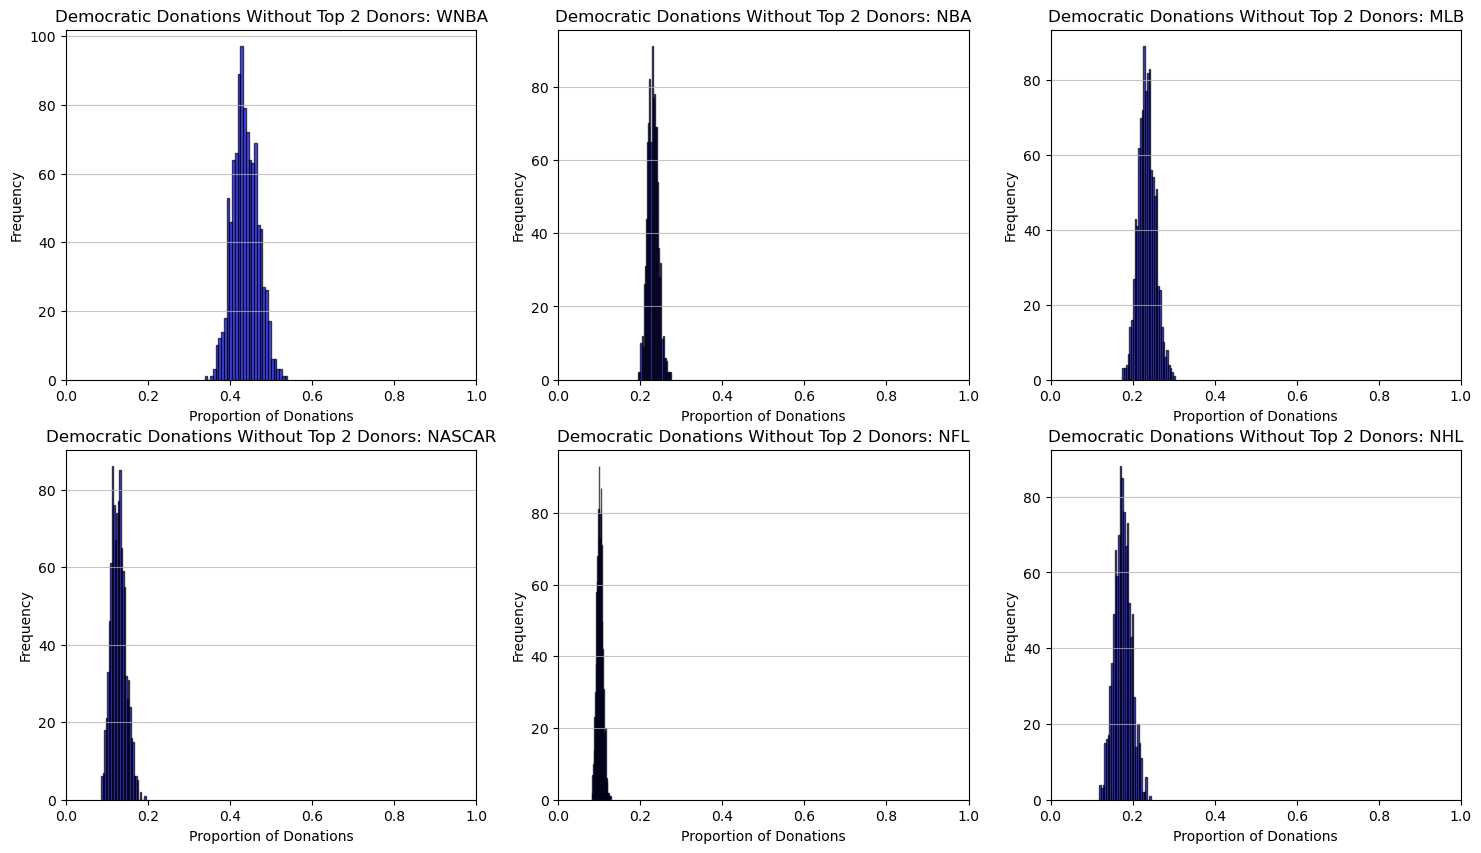

In [687]:
# Define the league names for labeling
leagues = ['WNBA', 'NBA', 'MLB', 'NASCAR', 'NFL', 'NHL']
proportions_list = [wnba_proportions_filtered, nba_proportions_filtered, mlb_proportions_filtered, 
                    nascar_proportions_filtered, nfl_proportions_filtered, nhl_proportions_filtered]

# Create histograms for each league
plt.figure(figsize=(18, 10))  

for i, proportions in enumerate(proportions_list):
    plt.subplot(2, 3, i + 1)  # Create a subplot for each league
    plt.hist(proportions, bins=30, alpha=0.7, color='blue', edgecolor = 'black')  # Create histogram
    plt.title(f'Democratic Donations Without Top 2 Donors: {leagues[i]}')  # Set the title for each subplot
    plt.xlabel('Proportion of Donations')  
    plt.ylabel('Frequency')  
    plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
    plt.grid(axis='y', alpha=0.75)  

plt.show()

### Closing Words on Part 2:
After doing a visual assessment of this confounding factor, removing the top 2 donors does not significantly change the data in any way. Obviously, the other confounding factors are still a strong possibility for explaining why WBNA owners donate more democratically, but more inference would have to be conducted to establish this.

## Part 3: Prediction 

The target of interest in my data is predominant political party donated to by location. Since I want to do logistic regression, I want binary categories, so I chose to encode democratic donations as 0 and other (bipartisan and republican) as 1. 

In my EDA section I explored the political party that was most donated to in the location of the sports teams, as re-graphed below:

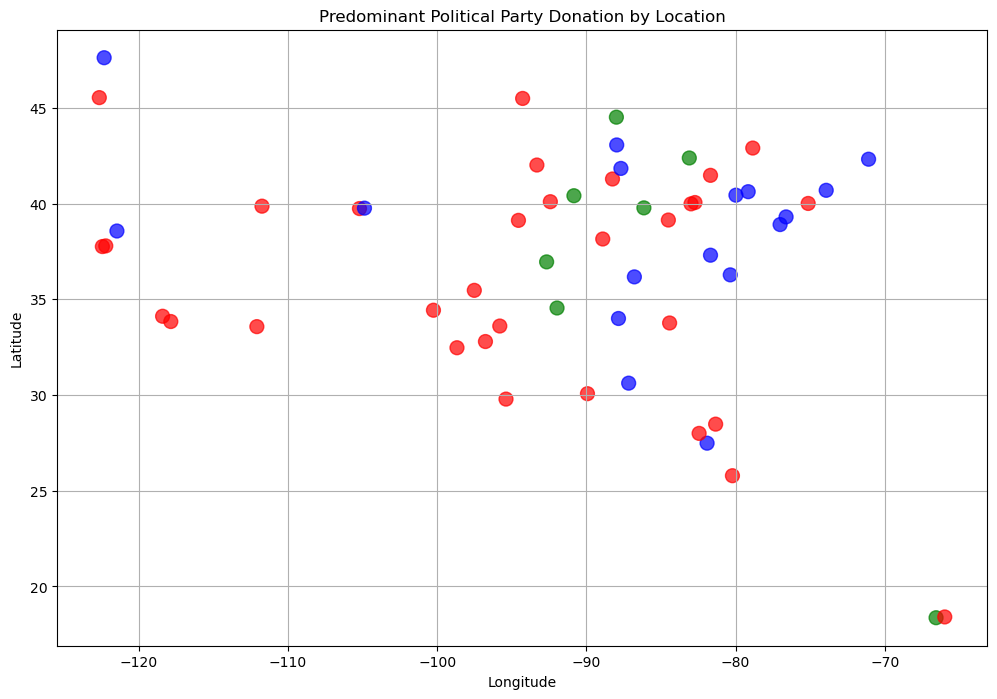

In [688]:
party_colors = {
    "DEMOCRAT": 'blue',
    "BIPARTISAN": 'green',
    "REPUBLICAN": 'red'
}

# Map the party to its corresponding color
location_predominant_party['color'] = location_predominant_party['Party'].map(party_colors)

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(
    location_predominant_party['longitude'],
    location_predominant_party['latitude'],
    c=location_predominant_party['color'],
    alpha=0.7,
    s=100
)

# Customize the plot
plt.title('Predominant Political Party Donation by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

In [689]:
location_grouped = location.groupby(['latitude', 'longitude', 'Party']).size().reset_index(name='count')
predominant_donations = location_grouped.loc[location_grouped.groupby(['latitude', 'longitude'])['count'].idxmax()]
predominant_donations.head()

,latitude,longitude,Party,count
0,18.3643,-66.5611,BIPARTISAN,3
2,18.4054,-65.9792,REPUBLICAN,37
5,25.7840,-80.2101,REPUBLICAN,152
6,27.4830,-81.9097,DEMOCRAT,3
9,27.9945,-82.4447,REPUBLICAN,19


Now, I create the binary values for the data set. 0 is dem causes and 1 is not dem causes, as shown below:

In [690]:
# Define the mapping of Party to binary values
party_mapping = {
    "DEMOCRAT": 0,
    "BIPARTISAN": 1,
    "REPUBLICAN": 1  # Combine both bipartisan and republican into 1
}

# Map the Party column to numeric values
predominant_donations['binary_party'] = predominant_donations['Party'].map(party_mapping)

# Drop the original Party and count columns
predominant_donations.drop(columns=["Party", "count"], inplace=True)

# Renaming latitude and longitude for easier use later on
predominant_donations.rename(columns={"latitude": "lat", "longitude": "lng"}, inplace=True)

# Display the updated dataset
predominant_donations.head()

,lat,lng,binary_party
0,18.3643,-66.5611,1
2,18.4054,-65.9792,1
5,25.7840,-80.2101,1
6,27.4830,-81.9097,0
9,27.9945,-82.4447,1


### Modeling framework: Logistic regression model using lat & long as predictors. 

I want to assess how lat & long act as predictors to binary_party. I assess lat & long independently, and then lat * long with lat & long. I use prediction and then KFold cross-validation to find the error across the folds.

In [710]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm

# Making the lat * long part of the dataframe
predominant_donations['lat_times_long'] = predominant_donations['lat'] * predominant_donations['lng']

# Define predictors and target
X1 = predominant_donations[['lat', 'lng']]
X2 = predominant_donations[['lat_times_long']]
X3 = predominant_donations[['lat', 'lng', 'lat_times_long']]
y = predominant_donations['binary_party']

# Initialize KFold for cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Model 1: Lat and Long as separate predictors
cv_scores1 = cross_val_score(LogisticRegression(), X1, y, cv=kf, scoring='accuracy')
print("Model 1 (Lat and Long Separately) Cross-Validation Scores:", cv_scores1)
print("Model 1 Mean Accuracy:", np.mean(cv_scores1))

X1_sm = sm.add_constant(X1)
result1_sm = sm.Logit(y, X1_sm).fit(disp=0)
print("\nP-Values for Model 1 (Lat and Long Separately):")
print(result1_sm.pvalues)

# Model 2: Lat * Long as the only predictor
cv_scores2 = cross_val_score(LogisticRegression(), X2, y, cv=kf, scoring='accuracy')
print("\nModel 2 (Lat * Long Only) Cross-Validation Scores:", cv_scores2)
print("Model 2 Mean Accuracy:", np.mean(cv_scores2))

X2_sm = sm.add_constant(X2)
result2_sm = sm.Logit(y, X2_sm).fit(disp=0)
print("\nP-Values for Model 2 (Lat * Long Only):")
print(result2_sm.pvalues)

# Model 3: Lat, Long, and Lat * Long together as predictors
cv_scores3 = cross_val_score(LogisticRegression(), X3, y, cv=kf, scoring='accuracy')
print("\nModel 3 (Lat, Long, and Lat * Long Together) Cross-Validation Scores:", cv_scores3)
print("Model 3 Mean Accuracy:", np.mean(cv_scores3))

X3_sm = sm.add_constant(X3)
result3_sm = sm.Logit(y, X3_sm).fit(disp=0)
print("\nP-Values for Model 3 (Lat, Long, and Lat * Long Together):")
print(result3_sm.pvalues)

Model 1 (Lat and Long Separately) Cross-Validation Scores: [0.71428571 0.57142857 0.71428571 0.57142857]
Model 1 Mean Accuracy: 0.6428571428571428

P-Values for Model 1 (Lat and Long Separately):
const    0.796756
lat      0.097563
lng      0.100145
dtype: float64

Model 2 (Lat * Long Only) Cross-Validation Scores: [0.85714286 0.57142857 0.78571429 0.57142857]
Model 2 Mean Accuracy: 0.6964285714285714

P-Values for Model 2 (Lat * Long Only):
const             0.537793
lat_times_long    0.948799
dtype: float64

Model 3 (Lat, Long, and Lat * Long Together) Cross-Validation Scores: [0.64285714 0.57142857 0.85714286 0.57142857]
Model 3 Mean Accuracy: 0.6607142857142858

P-Values for Model 3 (Lat, Long, and Lat * Long Together):
const             0.668422
lat               0.878175
lng               0.420266
lat_times_long    0.611538
dtype: float64


#### Findings from this:
The predictors (lat, lng, and lat_times_long) are not statistically significant individually or together, based on their p-values. This means that even though latitude and longitude might help my model accuracy, they might not themselves have a statistically significant relationship with the target variable of binary_party. This could suggest that other factors are more influential to the majority party donations.

All of the models are slightly more accurate than randomly guessing, which would be 0.5 accuracy, with lat * long only having the overall most mean accuracy.

Since model 3 (Lat, Long, and Lat * Long Together) shows a drop in mean accuracy compared to Model 2, this indicates that combining all three predictors might introduce some noise into the model.

#### Continuing with prediction:
I want to include the voting patterns in that geographic area as a factor to my prediction to see if it makes it more accurate or not. In other words, I am interested in if the geographical voting patterns will help train my model. This approach may help me determine whether geographic voting patterns have a significant impact on donation behaviors.

I read in a dataset with different counties and how they voted, then categorizing the county as 0 for dem and 1 for other in their voting patterns.

In [711]:
county_voting = pd.read_csv("county_info.csv")
county_voting.head()

,state,county_name,release,discrepancy,biden_cvr,biden_official,jorgensen_cvr,jorgensen_official,trump_cvr,trump_official,undervote_cvr,undervote_official
0,ALASKA,STATEWIDE,0,candidate missing,137638,153778.0,7851,8897.0,165487,189951.0,1501.0,NaN
1,ARIZONA,MARICOPA,1,0 difference,1040774,1040774.0,31705,31705.0,995665,995665.0,8475.0,NaN
2,ARIZONA,PIMA,1,0 difference,304981,304981.0,7658,7658.0,207758,207758.0,2382.0,NaN
3,ARIZONA,SANTA CRUZ,1,0 difference,13138,13138.0,224,224.0,6194,6194.0,NaN,NaN
4,ARIZONA,YUMA,1,0 difference,32210,32210.0,1137,1137.0,36534,36534.0,281.0,NaN


In [703]:
# Calculate proportions
county_voting['total_votes'] = county_voting['biden_official'] + county_voting['trump_official']

# Categorize based on vote counts
def categorize_voting(row):
    if row['biden_official'] > row['trump_official']:
        return 0  # Democrat majority
    else:
        return 1  # Not democrat majority ("other")

county_voting['majority_category'] = county_voting.apply(categorize_voting, axis=1)

county_voting.head()


,state,county_name,release,discrepancy,biden_cvr,biden_official,jorgensen_cvr,jorgensen_official,trump_cvr,trump_official,undervote_cvr,undervote_official,total_votes,majority_category
0,ALASKA,STATEWIDE,0,candidate missing,137638,153778.0,7851,8897.0,165487,189951.0,1501.0,NaN,343729.0,1
1,ARIZONA,MARICOPA,1,0 difference,1040774,1040774.0,31705,31705.0,995665,995665.0,8475.0,NaN,2036439.0,0
2,ARIZONA,PIMA,1,0 difference,304981,304981.0,7658,7658.0,207758,207758.0,2382.0,NaN,512739.0,0
3,ARIZONA,SANTA CRUZ,1,0 difference,13138,13138.0,224,224.0,6194,6194.0,NaN,NaN,19332.0,0
4,ARIZONA,YUMA,1,0 difference,32210,32210.0,1137,1137.0,36534,36534.0,281.0,NaN,68744.0,1


Then, since my county data set did not include lat and long, I added in another data set with the lat and long, merging them together with only the relevant info I will need later.

In [704]:
county_latlng = pd.read_csv("uscounties.csv")
county_latlng.head()

,county,county_ascii,county_full,county_fips,state_id,state_name,lat,lng,population
0,Los Angeles,Los Angeles,Los Angeles County,6037,CA,California,34.3219,-118.2247,9936690
1,Cook,Cook,Cook County,17031,IL,Illinois,41.8401,-87.8168,5225367
2,Harris,Harris,Harris County,48201,TX,Texas,29.8578,-95.3938,4726177
3,Maricopa,Maricopa,Maricopa County,4013,AZ,Arizona,33.3490,-112.4915,4430871
4,San Diego,San Diego,San Diego County,6073,CA,California,33.0343,-116.7350,3289701


In [706]:
# Standardize column names
county_latlng.rename(columns={'county': 'County'}, inplace=True)
county_voting.rename(columns={'county_name': 'County'}, inplace=True)

# Convert County names to uppercase for both datasets
county_latlng['County'] = county_latlng['County'].str.upper()
county_voting['County'] = county_voting['County'].str.upper()

# Merge the datasets on County and State & drop not important ones
lat_long_majority = pd.merge(county_latlng, county_voting, on=["County"], how="inner")
location_predominant_party = lat_long_majority[['lat', 'lng', 'majority_category']]
location_predominant_party.head()

,lat,lng,majority_category
0,34.3219,-118.2247,0
1,41.8401,-87.8168,1
2,29.8578,-95.3938,1
3,33.3490,-112.4915,0
4,33.0343,-116.7350,0


Since my predominant_donation dataset doesn't have the exact same lat and long as this data set, I made a function to find the closest one, and then aligned that with the majority_category in that area.

In [707]:
# Find the closest lat/lng for each donation
def find_closest_lat_lng(donations, majority):
    closest_majority = []
    for index, row in donations.iterrows():
        distances = np.sqrt((majority['lat'] - row['lat'])**2 + (majority['lng'] - row['lng'])**2)
        closest_index = distances.idxmin()
        closest_majority.append(majority.loc[closest_index, 'majority_category'])
    return closest_majority

# Merge the datasets
predominant_donations['majority_category'] = find_closest_lat_lng(
    predominant_donations, lat_long_majority
)
predominant_donations.head()

,lat,lng,binary_party,lat_times_long,majority_category
0,18.3643,-66.5611,1,-1222.348009,0
2,18.4054,-65.9792,1,-1214.373568,0
5,25.7840,-80.2101,1,-2068.137218,0
6,27.4830,-81.9097,0,-2251.124285,1
9,27.9945,-82.4447,1,-2307.998154,0


Now, I want to use the majority voting patterns as predictors in my donation analysis. 

In [708]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Define predictors and target
X = predominant_donations[['majority_category']] 
y = predominant_donations['binary_party']         

# Set up k-fold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)
model = LogisticRegression()

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Print cross-validation results
print("Model Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Add constant for statsmodels
X_sm = sm.add_constant(X)

# Fit logistic regression model using statsmodels for p-values
model_sm = sm.Logit(y, X_sm)
result_sm = model_sm.fit(disp=0)  # Suppress fitting output

# Print p-values
print("\nP-Values for Model:")
print(result_sm.pvalues)

Model Cross-Validation Scores: [0.85714286 0.57142857 0.78571429 0.57142857]
Mean Accuracy: 0.6964285714285714

P-Values for Model:
const                0.033980
majority_category    0.730631
dtype: float64


#### Findings from this:
The high p-value suggests that there isn't strong evidence to support the claim that majority_category has a meaningful relationship with the likelihood of donations of a binary_party. However, the mean accuracy is slightly higher than using the latitude and longitude, which suggests it is at the very least not worse at predicting.

## PART 3 CONCLUSIONS:

Overall, Lat * Long Only and using the majority_category in that area were both accurate models around 70% of the time. All of my models had high p-values, but just because these predictors might not be statistically significant (high p-value), they could still be contributing to some form of prediction accuracy due to correlations or indirect effects. I believe that the binary encoding decreased some of the nuance as I was assessing whether or not the donations went to dems or not, and I could not use the bipartisan data. 

## FINAL THOUGHTS:

I would be interested in moving away from geographical data as it was difficult considering that the teams did not have the easiest way to accesss latitude and longitude. Looking into the future I would like to see if the donations actually influenced the election results. Overall, I am satisified with my project and how I got familiarized looking at political data on my own. I am very interested in applying data science to politics, so this was a great first step into working with data on my own.